In [1]:
!pip install -qU diffusers
!pip install -qU accelerate
!pip install -qU peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 7.5 MB/s eta 0:00:00


- 여기서 세션 다시 시작

In [1]:
# 모델 파일
!gdown 195T-Rf3DZMgNk7KA9RoViP5aFMst1lxS

Downloading...
From (original): https://drive.google.com/uc?id=195T-Rf3DZMgNk7KA9RoViP5aFMst1lxS
From (redirected): https://drive.google.com/uc?id=195T-Rf3DZMgNk7KA9RoViP5aFMst1lxS&confirm=t&uuid=c7083e36-e73f-43ed-a03f-779d56ac00c4
To: /content/catCitronAnimeTreasure_sdxl.safetensors
100% 6.94G/6.94G [01:45<00:00, 65.7MB/s]


In [2]:
# 로라 파일
!gdown 18xOkxCWqZhPMLGoI5TkxFACWHBn6HFrk

Downloading...
From (original): https://drive.google.com/uc?id=18xOkxCWqZhPMLGoI5TkxFACWHBn6HFrk
From (redirected): https://drive.google.com/uc?id=18xOkxCWqZhPMLGoI5TkxFACWHBn6HFrk&confirm=t&uuid=70db081a-e36e-47f0-a4e7-3b1ba028f57f
To: /content/pixel-art-xl-v1.1.safetensors
100% 171M/171M [00:06<00:00, 26.0MB/s]


In [3]:
# VAE 파일
!gdown 193GEtxclNibsz65bOL0uwYnQldwfI5nf

Downloading...
From (original): https://drive.google.com/uc?id=193GEtxclNibsz65bOL0uwYnQldwfI5nf
From (redirected): https://drive.google.com/uc?id=193GEtxclNibsz65bOL0uwYnQldwfI5nf&confirm=t&uuid=1012cb82-29db-4f8a-9ee2-e154a183a673
To: /content/pppanimixVAE_XL.safetensors
100% 167M/167M [00:03<00:00, 43.1MB/s]


In [4]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import transformers, diffusers, huggingface_hub
from diffusers import StableDiffusionXLPipeline
from diffusers import EulerDiscreteScheduler, DPMSolverMultistepScheduler
from diffusers import AutoencoderKL

In [5]:
transformers.__version__, diffusers.__version__

('4.44.2', '0.30.3')

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
# huggingface_hub.login()

In [35]:
repo_id = "./catCitronAnimeTreasure_sdxl.safetensors"

# https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/text2img#diffusers.StableDiffusionPipeline.from_single_file
pipeline = StableDiffusionXLPipeline.from_single_file(
    pretrained_model_link_or_path=repo_id,
    # 특정 vae를 쓸때 에러 날 수 있음
    # vae가 float16을 지원하지 않는 경우
    # RuntimeError: Input type (struct c10::Half) and bias type (float) should be the same
    # 같은 이유로 web-ui도 --no-half-vae 옵션이 있음
    # 특정 vae를 사용하지 않거나 float16지원하는 vae라면 이 옵션을 키면 속도가 빨라짐
    torch_dtype=torch.float16
).to(device)


Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Some weights of the model checkpoint were not used when initializing CLIPTextModel: 
 ['text_model.embeddings.position_ids']


In [22]:
seed = 13208945

In [38]:
prompt = "Starry Night: A detailed rendering of Van Gogh's Starry Night, \
emphasizing the swirling brushstrokes and vibrant colors. \
Explore the dynamic movement of the stars, the contrasting colors of \
the night sky and the village, and the emotional intensity conveyed by the artwork."

negative_prompt = "ugly, wrong, bad, blur, blurry, blurred, out of focus,"

In [39]:
generator1 = torch.Generator(device="cuda").manual_seed(seed)

image1 = pipeline(
    prompt=prompt,
    negative_prompt=negative_prompt,
    width=720, height=1024, # 잠재변수가 1/8로 줄기 때문에 8의 배수가 되게
    guidance_scale=7,
    num_inference_steps=30,
    generator=generator1,
).images[0]

image1

Output hidden; open in https://colab.research.google.com to view.

In [25]:
########################################################
# scheduler
# 스케쥴러 이름 설명
# https://www.reddit.com/r/StableDiffusion/comments/16wykzy/ever_wondered_what_those_cryptic_sampler_names/
pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)


In [26]:
generator1 = torch.Generator(device="cuda").manual_seed(seed)

image2 = pipeline(
    prompt=prompt,
    negative_prompt=negative_prompt,
    width=720, height=1024,
    guidance_scale=7,
    num_inference_steps=30,
    generator=generator1,
).images[0]

image2

Output hidden; open in https://colab.research.google.com to view.

In [27]:
########################################################
# vae
# https://civitai.com/models/285852/pppanimix-vae?modelVersionId=572204
original_vae = pipeline.vae
url = "pppanimixVAE_XL.safetensors"
vae = AutoencoderKL.from_single_file(url, torch_dtype=torch.float16).to(device)
pipeline.vae = vae



In [28]:
generator1 = torch.Generator(device="cuda").manual_seed(seed)

image3 = pipeline(
    prompt=prompt,
    negative_prompt=negative_prompt,
    width=720, height=1024,
    guidance_scale=7,
    num_inference_steps=30,
    generator=generator1,
).images[0]

image3

Output hidden; open in https://colab.research.google.com to view.

In [29]:
########################################################
# lora
# https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/text2img#diffusers.StableDiffusionPipeline.load_lora_weights
# https://civitai.com/models/120096/pixel-art-xl?modelVersionId=135931
pipeline.load_lora_weights("pixel-art-xl-v1.1.safetensors")
# https://huggingface.co/docs/diffusers/using-diffusers/merge_loras#fuselora
pipeline.fuse_lora(lora_scale=1.5)

  0%|          | 0/30 [00:00<?, ?it/s]

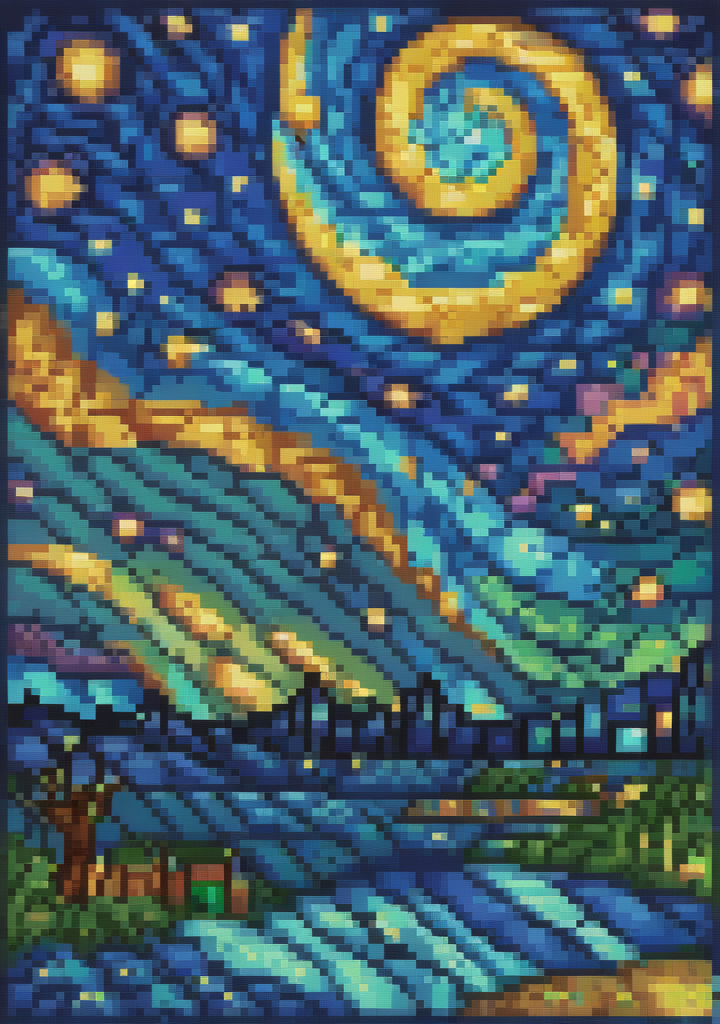

In [30]:
generator1 = torch.Generator(device="cuda").manual_seed(seed)

image4 = pipeline(
    prompt=prompt,
    negative_prompt=negative_prompt,
    width=720, height=1024,
    guidance_scale=7,
    num_inference_steps=30,
    generator=generator1,
).images[0]

image4

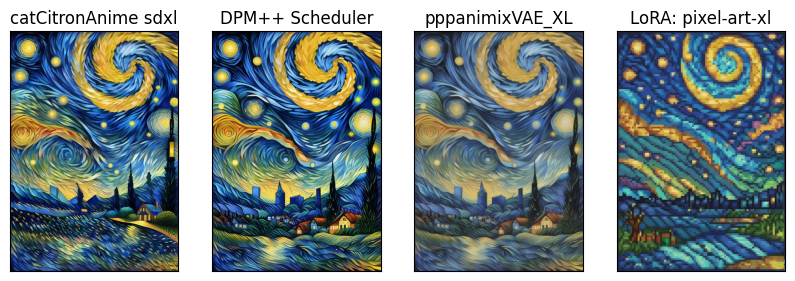

In [32]:
fig, axs = plt.subplots(figsize=(10,5), nrows=1, ncols=4)

axs[0].imshow(image1)
axs[0].xaxis.set_major_locator(plt.NullLocator())
axs[0].yaxis.set_major_locator(plt.NullLocator())
axs[0].set_title('catCitronAnime sdxl')

axs[1].imshow(image2)
axs[1].xaxis.set_major_locator(plt.NullLocator())
axs[1].yaxis.set_major_locator(plt.NullLocator())
axs[1].set_title('DPM++ Scheduler')

axs[2].imshow(image3)
axs[2].xaxis.set_major_locator(plt.NullLocator())
axs[2].yaxis.set_major_locator(plt.NullLocator())
axs[2].set_title('pppanimixVAE_XL')

axs[3].imshow(image4)
axs[3].xaxis.set_major_locator(plt.NullLocator())
axs[3].yaxis.set_major_locator(plt.NullLocator())
axs[3].set_title('LoRA: pixel-art-xl')

plt.show()